# A complete descriptive statistics NoteBook

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import types
import sys
from numbers import Real, Integral

# Create a fake module to emulate 'sklearn.utils._param_validation'
# (used by skglm in newer versions of scikit-learn, >=1.3)
param_validation = types.ModuleType("sklearn.utils._param_validation")

# Define a minimal replacement for Interval used in _parameter_constraints
class Interval:
    def __init__(self, dtype, left, right, closed="neither"):
        self.dtype = dtype
        self.left = left
        self.right = right
        self.closed = closed

# Define a minimal replacement for StrOptions used in _parameter_constraints
class StrOptions:
    def __init__(self, options):
        self.options = set(options)

# Add the custom classes to the fake module
param_validation.Interval = Interval
param_validation.StrOptions = StrOptions

# Inject the fake module into sys.modules before skglm is imported
# This prevents skglm from raising an ImportError if sklearn < 1.3
sys.modules["sklearn.utils._param_validation"] = param_validation

In [3]:
import os

# Add the src directory to the Python path
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src/multisigbert'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Now import our custom modules
from _utils import *
from descriptive_stats_pkg import *

/Applications/anaconda3/envs/multisigbert-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I) Data Importation

In [5]:
# Path to the CSV file
file_path = ".../data/df_study_real_L36_w12.csv"
df_all, id_list_multimodal = load_dataframe_and_extract_unique_ids(file_path, id_column="ID")

DataFrame loaded successfully. Shape: (19448, 19)
Number of unique IDs in column 'ID': 2527
First 10 IDs: ['r-10105825', 'r-10131802', 'r-10136016', 'r-10148837', 'r-1015519', 'r-10155288', 'r-10180109', 'r-10214213', 'r-10234006', 'r-10263499']


In [6]:
df_OG = global_data_import(path_import = "../data/data_real.csv", nrows=None, conformal_list=id_list_multimodal)


----- Total import time: 59.56 seconds (0.99 minutes)
Number of unique patients: 2527


In [7]:
df_OG.head(3)

,ID,date_creation,DEATH,date_death,date_end,date_start,Source,embeddings
0,r-10136016,2016-01-07,1,2016-06-23,2016-06-23,2013-02-25,Compte-rendu de consultation,"[0.002955587921463108, 0.011114062370347599, -..."
1,r-10136016,2016-03-02,1,2016-06-23,2016-06-23,2013-02-25,Compte-rendu de consultation,"[0.0025969198343353942, 0.007027378535048044, ..."
2,r-10136016,2015-06-01,1,2016-06-23,2016-06-23,2013-02-25,Compte-rendu de séjour,"[-0.0001925998130765812, 0.005702302682523925,..."


In [8]:
Ndays = 100
df_all, nbr_id_removed, min_days_difference = run_global_data_filtering(df_OG, Ndays)

Method selected: constant with a fixed cutoff of 100 days.
Initial number of unique IDs: 2527
Number of unique IDs after filtering: 2527
Number of modified IDs: 0 (0.00%)
Filtering completed with min_days_gap = 100 days.
0 observations were removed.

Minimum time between last report and date_death: 100 days
No patients removed. All records are consistent.
------------------------------
Number of deceased patients = 1629 (64.46%)
Average number of reports per patient: 49
Total number of valid patients: 2527
Total number of deceased patients: 1629 (64.5%)
Minimum time difference between reports after filtering: 100 days
Number of patients removed during cleaning: 0


In [9]:
# Train-Test Split
df_train_new_OG, test_groups = make_train_test(df_OG)

# Descriptives Stats

In [10]:
print_dataset_statistics(df_OG)

Total number of patients in the dataset: 2527
Total number of medical reports: 124049
Average number of reports per patient: 49.09
Number of deceased patients: 1629
Number of censored patients: 898


In [11]:
# define good_ID_multimodal as the list of IDs from df_OG['ID']
good_ID_multimodal = df_OG['ID'].drop_duplicates().tolist()

## Cancer type repartition

In [12]:
df_ippr_conforme = pd.DataFrame({"IPPR": id_list_multimodal})
path_fiche_tum = '../fiches-tumeurs.csv'
path_libelle_map = '../libelle_possible_general.xlsx'

In [13]:
df_cancer_id, nb_common_ids, percentage_common = build_cancer_category_dataframe(
    # Source of conform IDs
    df_id_source=df_ippr_conforme,          # DataFrame containing IPPR
    id_column_source="IPPR",                # Original column name
    
    # Tumor registry file
    path_fiche_tumeur_csv=path_fiche_tum,
    fiche_id_column="IPPR",
    topo_column="CODE_CIMO_TOPOGRAPHIE",
    
    # Mapping file
    path_mapping_excel=path_libelle_map,
    mapping_topo_column="TOPO_SHORT",
    mapping_category_column="Categorie_generale",
    
    # Reference dataset for overlap computation
    df_reference=df_OG,
    reference_id_column="ID",
    fiche_sep=";",
    
    # Category replacements
    category_replacements={
        "Cancers masculins (Prostate, reproduction)": "Prostate",
        "Hematologique et systeme lymphatique": "Lymphe"
    },
    
    verbose=True
)

Number of common IDs: 2506
Percentage of common IDs: 99.17%


In [14]:
mapping_translation = {
    "french": [
        'Gynecologique', 'Sein', 'Neurologique', 'Intestin', 'Tete et cou',
        'Urologique', 'Poumon', 'Sarcome', 'Peau', 'Prostate', 'Coeur',
        'Autre ou inconnu', 'Endocrinien', 'Lymphe', 'Péritoine',
        'Os', 'Foie', 'Bouche', 'Estomac'
    ],
    "eng": [
        'Gynecological', 'Breast', 'Neurological', 'Intestine', 'Head and neck',
        'Urological', 'Lung', 'Sarcoma', 'Skin', 'Prostate', 'Heart',
        'Other or unknown', 'Endocrine', 'Lymph', 'Peritoneum',
        'Bone', 'Liver', 'Mouth', 'Stomach'
    ]
}

fr_to_eng = dict(zip(mapping_translation["french"], mapping_translation["eng"]))

In [15]:
df_cancer_id_encoded = encode_and_complete_cancer_categories(
    df_cancer_id=df_cancer_id,
    id_column="ID",
    category_column="Categorie_generale",
    df_reference=df_OG,
    reference_id_column="ID",
    translation_dict=fr_to_eng,
    default_category="Other or unknown",
    good_id_list=good_ID_multimodal,   # can be list or set
    verbose=True
)

Number of reference IDs: 2527
Number of common IDs: 2506
Number of missing IDs added: 21
Final dataset size: (2527, 2)


.../src/multisigbert/descriptive_stats_pkg.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Figure saved to: ../results/descriptive_statistics/repartition_cancer_eng.png


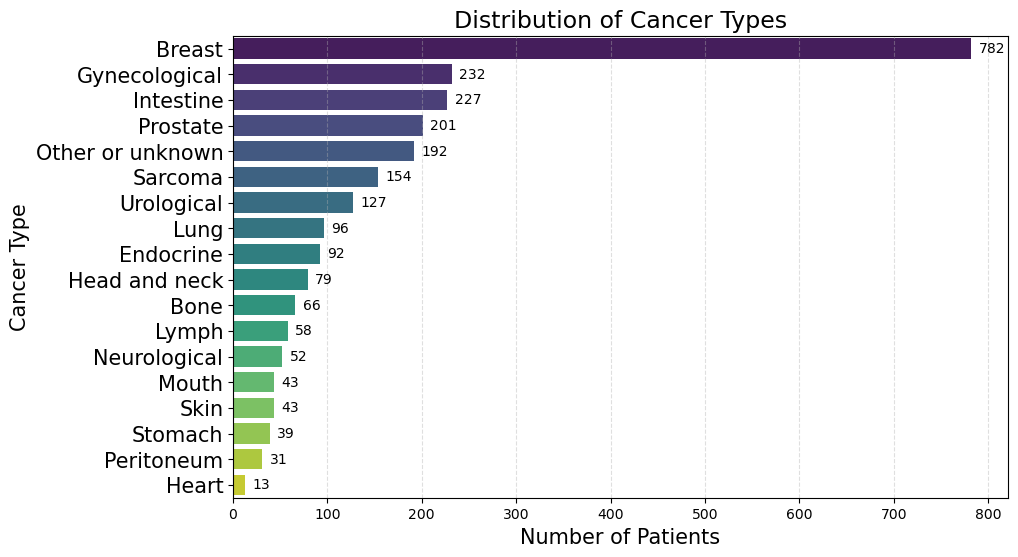

Cancer distribution plot generated successfully.


Categorie_generale
Breast              782
Gynecological       232
Intestine           227
Prostate            201
Other or unknown    192
Sarcoma             154
Urological          127
Lung                 96
Endocrine            92
Head and neck        79
Bone                 66
Lymph                58
Neurological         52
Mouth                43
Skin                 43
Stomach              39
Peritoneum           31
Heart                13
Name: count, dtype: int64

In [27]:
plot_cancer_distribution(
    df = df_cancer_id_encoded,
    category_column = "Categorie_generale",
    save_path='../results/descriptive_statistics/repartition_cancer_eng.png'
)

## Type of reports

In [17]:
mapping_dic = {
    'Compte-rendu de consultation avancée': 'Compte-rendu de consultation',
    'Adolescents et jeunes adultes': 'Compte-rendu de consultation',
    'CR d’oncogériatrie': 'Compte-rendu de consultation',
    'RCP compte-rendu': 'Compte-rendu de consultation'
}

In [18]:
source_translation = {
    "french": [
        'Compte-rendu de consultation', 
        'Compte-rendu de séjour',
        'Consultation de suivi pendant le traitement',
        'Compte-rendu de consultation avec actes',
        'Compte-rendu de sortie'
    ],
    "eng": [
        'Consultation Report', 
        'Hospital Stay Report',
        'Follow-up Consultation During Treatment',
        'Consultation Report with Procedures',
        'Discharge Report'
    ]
}

fr_to_eng_source = dict(
    zip(source_translation["french"], source_translation["eng"])
)

Figure saved to: ../results/descriptive_statistics/source_repartition_eng.png


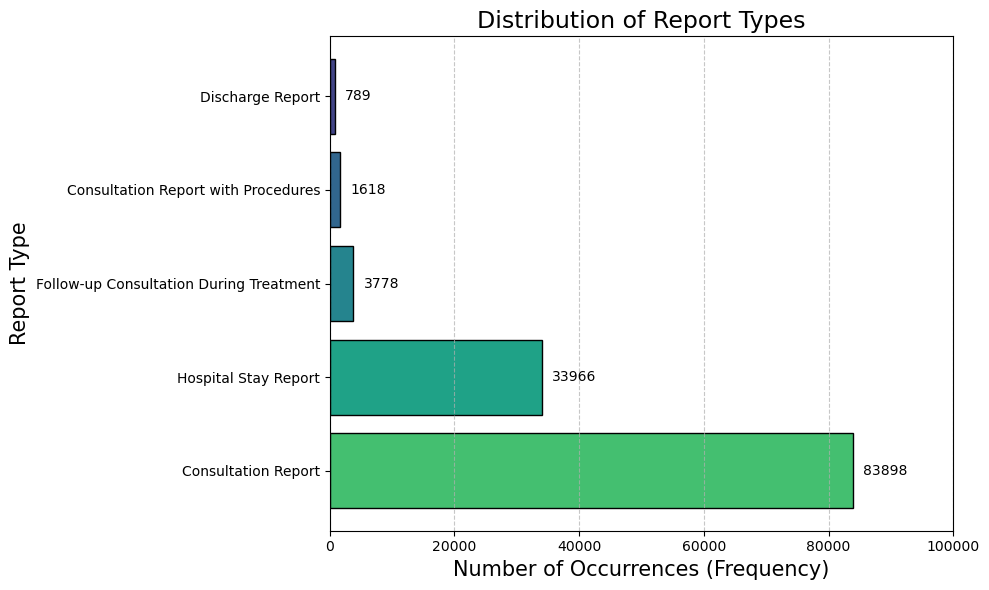

Source distribution plotted successfully.


In [19]:
source_counts = plot_translated_source_distribution(
    df=df_all,
    source_column="Source",
    regroup_dict=mapping_dic,
    translation_dict=fr_to_eng_source,
    xlim=(0, 100000),
    save_path="../results/descriptive_statistics/source_repartition_eng.png",
    verbose=True
)

## Distributions of reports number

Figure saved to: ../results/descriptive_statistics/nbr_reports_per_patients.png


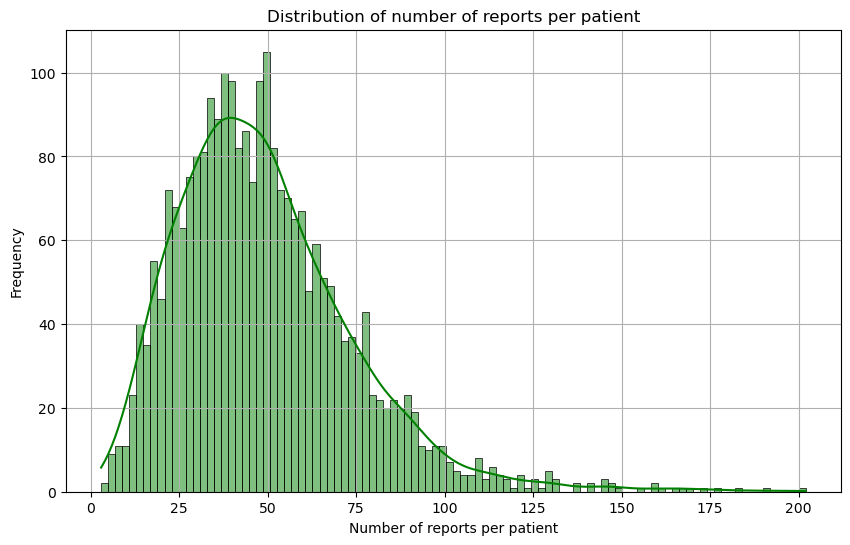

Total number of patients: 2527
Mean number of reports per patient: 49.09 (sd 25.12).
Median number of reports per patient: 46.00
Maximum number of reports for a single patient: 202


In [20]:
report_counts = plot_reports_per_patient_distribution(
    df=df_all,
    id_column="ID",
    bins=100,
    kde=True,
    color="green",
    save_path="../results/descriptive_statistics/nbr_reports_per_patients.png",
    verbose=True
)

## Distribution de la durée d'étude

In [21]:
columns_to_keep = ['ID', 'date_creation', 'DEATH', 'date_death', 'date_end', 'date_start']
df_info = make_df_info(df=df_all, columns_to_keep=columns_to_keep)

Number of patients: 2527


Figure saved to: ../results/descriptive_statistics/duration_distribution.png


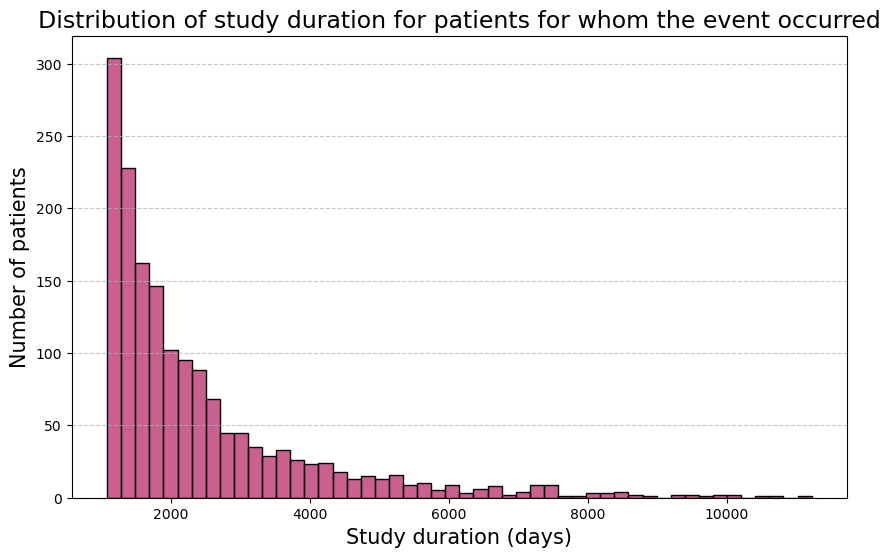

Summary statistics for event cases:
count     1629.000000
mean      2427.415592
std       1582.430161
min       1082.000000
25%       1373.000000
50%       1846.000000
75%       2833.000000
max      11220.000000
Name: duration, dtype: float64


In [22]:
df_deceased, summary_stats = plot_event_duration_distribution(
    df_info=df_info,
    event_column="DEATH",
    duration_column="duration",
    event_value=1,
    bins=50,
    save_path="../results/descriptive_statistics/duration_distribution.png",
    verbose=True
)

## Distribution of diagnosis date

In [23]:
df_ft = pd.read_csv(
    '../fiches-tumeurs.csv',
    sep=";"
)

df_ft = df_ft.rename(columns={"IPPR": "ID"})

In [24]:
id_conforme_list = (
    df_ippr_conforme
    .rename(columns={"IPPR": "ID"})["ID"]
    .dropna()
    .unique()
    .tolist()
)

Earliest date: 1960-06-15 00:00:00
Latest date: 2022-09-19 00:00:00
Mode (most frequent date): 1999-06-15 00:00:00
5th percentile (P5): 1995-04-28 12:00:00
Median date (P50): 2011-01-05 00:00:00
95th percentile (P95): 2018-06-22 20:23:59.999999744
Number of patients: 2370
Figure saved to: ../results/descriptive_statistics/distrib_diag_dates.png


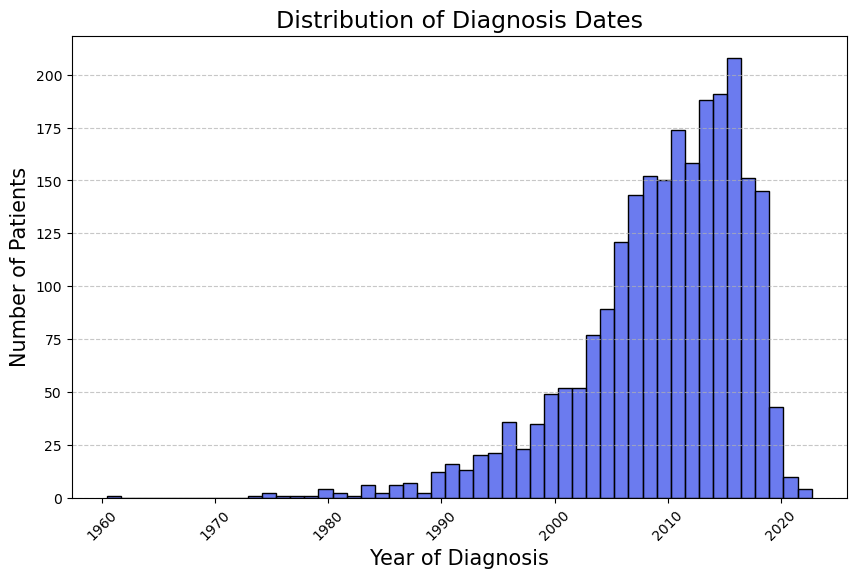

In [25]:
df_earliest, stats = describe_and_plot_earliest_diagnosis_dates(
    df_ft=df_ft,
    id_column="ID",
    diag_date_column="DATE_DIAG",
    compliant_ids=id_conforme_list,
    bins=50,
    color="#2C43E9",
    save_path='../results/descriptive_statistics/distrib_diag_dates.png',
    verbose=True
)

## Kaplan Meier Curves : Train Vs Validation

Figure saved to: ../results/descriptive_statistics/KM-curves.png


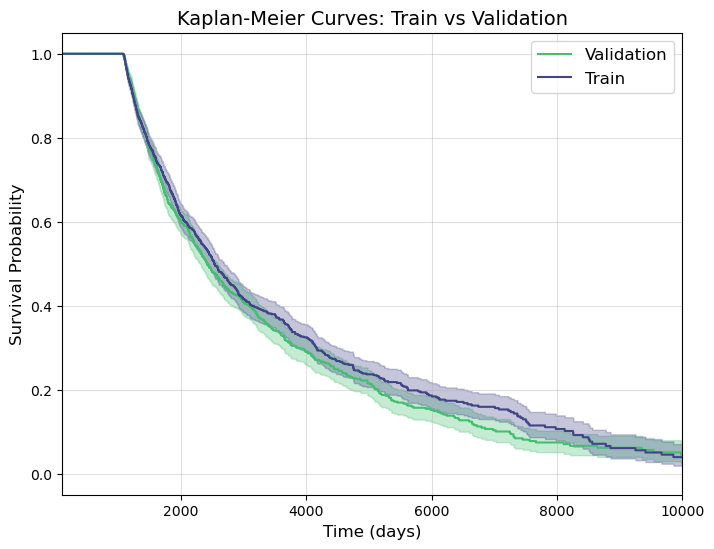

Log-rank summary:
   test_statistic         p  -log2(p)
0         2.49214  0.114416  3.127639
Log-rank p-value = 0.1144

Median event time (Train) for DEATH == 1: 1890.00 days
Median event time (Validation) for DEATH == 1: 1793.00 days
Train cohort size: 1263 patients
Validation cohort size: 1264 patients


In [26]:
(
    df_info_train,
    df_info_val,
    logrank_results,
    median_event_time_train,
    median_event_time_val
) = plot_km_train_vs_validation_with_logrank(

    df_info=df_info,
    id_column="ID",
    duration_column="duration",
    event_column="DEATH",

    df_train=df_train_new_OG,
    test_groups=test_groups,
    conform_ids=id_conforme_list,
    train_id_column="ID",
    test_id_column="ID",
    xlim=(110, 10000),
    save_path='../results/descriptive_statistics/KM-curves.png',
    verbose=True
)